In [97]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import itertools
import colorlover as cl
import random
import plotly.graph_objs as go
import sys

from datetime import datetime, timedelta, date
from collections import defaultdict
from sklearn.ensemble import IsolationForest
from plotly.offline import init_notebook_mode, plot, iplot

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

## ML models

In [80]:
def predict(model, X):
    
    model_predict = pd.DataFrame()
    host_cons = [(host,group) for host,group in X.drop_duplicates(['host', 'consumer_group'])[['host', 'consumer_group']].values]
    
    for (host,consumer_group) in host_cons:
        sample = X[(X.host == host) & (X.consumer_group == consumer_group)].set_index(['time', 'host', 'consumer_group'])
        predict = model.fit(sample).predict(sample)        
        model_predict = pd.concat([model_predict, pd.DataFrame(predict, columns=['is_anomaly'])], sort=False)
        
    return pd.concat([X[['time','host','consumer_group']], model_predict.reset_index(drop=True)], axis=1, sort=False)

Базовая идея метода «Локального уровня выброса» — сравнение локальной плотности точки с плотностями её соседей. 
Точка A имеет меньшую плотность по сравнению с соседями
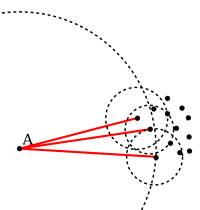

## Autoencoders

In [88]:
def autoencoder_predict(X, noise=0):

    dim = X.shape[1]
    
    X_input = Input(shape=(dim,))
    encoded = Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5))(X_input)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(dim, activation='sigmoid')(decoded)
    
    autoencoder = Model(X_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=5)
    autoencoder.fit(X + np.clip(noise * np.random.normal(loc=0.0, scale=1.0, size=dim),0,1), 
                    X,
                    epochs=1000,
                    batch_size=128,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[earlystopper])
    autoencoder_predict = autoencoder.predict(X)
    
    rmse = pd.DataFrame(np.sqrt(np.mean(np.power(X.values - autoencoder_predict, 2), axis=1)),columns=['rmse'])
    mse = pd.DataFrame(np.mean(np.power(X.values - autoencoder_predict, 2), axis=1),columns=['mse'])
    error_ae = pd.concat([X.reset_index()[['time','host','consumer_group']], rmse, mse],axis=1,sort=False)

    plt.plot(error_ae[['time']], error_ae[['mse']], '*')
    plt.xticks(rotation='vertical')
    
    return error_ae

## Visualization

In [46]:
def show_forecast(X, metrics, consumer_group, anomaly=None):
    ''' Visualization function
    '''
    
    # бага с legend doubleclick

    colors=[color for color in cl.flipper()['seq']['9'].values()]
    data_host=defaultdict(list)

    hosts=X.host.unique()
    for i,host in enumerate(hosts):
        fact_data=[]
        if i==0: 
            ButtonVisible=True
        else: 
            ButtonVisible=False

        anomaly_data = [go.Scatter(
            x=[anomaly[anomaly.host==host].iloc[i].time,anomaly[anomaly.host==host].iloc[i].time+timedelta(hours=1)],
            y=[1,1],
            fill='tozeroy',
            fillcolor='rgba(190,127,188,0.5)',
            line=dict(width=0),
            mode= 'none',
            showlegend=False,
            visible=ButtonVisible
        ) for i in range(len(anomaly[anomaly.host==host]))]
        
           
        # фактические значения
        for j,metric in enumerate(metrics):
            
            dash='longdash'
            
            if j%2==0:
                dash='solid'
            elif j%3==0:
                dash='dash'
            elif j%5==0:
                dash='dot'

            
            if (ButtonVisible==True) & (j!=0): 
                ButtonVisible='legendonly'
                
            colorpal=random.randint(0,len(colors)-1)
            fact_data.append(go.Scatter(
                name=str(metric),
                #legendgroup=str(metric),     
                #showlegend= False,
                x=X[X.host==host].time,
                y=X[X.host==host][metric].values,
                mode='lines',
                line=dict(color=colors[colorpal][i+3],
                          dash=dash,
                          width=2
                           ),
                visible=ButtonVisible
                )) 

        data_host[host]=list(filter(None.__ne__,[*fact_data,*anomaly_data]))

    updatemenus = list([
    dict(type="buttons",
         x = -0.07,
         buttons=list([
        dict(label='Host '+str(hostname),
          method = 'update',
          args = [
              {'visible':list(itertools.chain.from_iterable([([True]+(len(metrics)-1)*['legendonly']+(len(values)-len(metrics))*[True]) if host==hostname else len(values)*[False] for host,values in data_host.items()]
          )) },
             ])
        for i,hostname in enumerate(hosts) 
         ])
        )
 ])


    layout = dict(title=consumer_group, 
                  showlegend=True,
                  updatemenus=updatemenus,

                  xaxis=dict(
                      range=['2018-11-12','2018-11-14'],
                      rangeselector=dict(
                          buttons=list([
                              dict(count=1,
                                   label='1d',
                                   step='day',
                                   stepmode='backward'),
                              dict(count=7,
                                   label='1w',
                                   step='day',
                                   stepmode='backward'),
                              dict(count=1,
                                   label='1m',
                                   step='month',
                                   stepmode='backward'),
                              dict(step='all',
                                   stepmode='backward')
                          ]),
                      ),
                      rangeslider=dict(
                          visible = True
                      ),
                      type='date'
                  ),
                  yaxis=dict(
                      ticks='outside',
                      zeroline=False
                  ),
                 )
    return dict(data=list(itertools.chain.from_iterable([value for key,value in data_host.items()])), layout=layout)


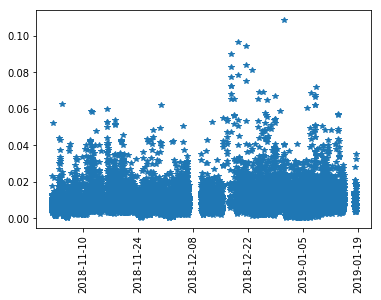

In [103]:
#if __name__ == "__main__":
    
#    outliers_fraction = float(sys.argv[1]) if len(sys.argv)>1 else 0.015

if True:
    
    outliers_fraction = 0.015
    
    df = pd.read_csv('../features/clear_data/rm_features.csv', ';', infer_datetime_format=True, parse_dates=['time'])

    # IsolationForest
    model_IF = IsolationForest(contamination=outliers_fraction, n_estimators=500, bootstrap=True)
    IF_predict = predict(model_IF, df)

    # AutoEncoder
    ae_predict = autoencoder_predict(df.set_index(['time','host','consumer_group']), 0.2)
    quantile = ae_predict.mse.quantile(1-outliers_fraction)
    
    anomaly_predict = ae_predict[ae_predict.mse > quantile].set_index(['time', 'host', 'consumer_group']).join(IF_predict[IF_predict.is_anomaly == -1].set_index(['time', 'host', 'consumer_group']),how='inner').reset_index()

    consumer_group = 'szb_sandbox_group'
    fig_reqs = show_forecast(df[df.consumer_group == consumer_group], df.drop(columns=['time','host','consumer_group']).columns, consumer_group, anomaly_predict[anomaly_predict.consumer_group == consumer_group])
    iplot(fig_reqs)
    
    plot(fig_reqs, filename='../results/report.html')
    